# Week - 7 Excercise - 1 - DSE 3159
By-

Pratinav Seth 200968216

### Using the following data set: https://www.kaggle.com/code/cemalefetezcan/imdb-review-sentiment-classification

#### Divide the data into train/validation data sets, build 2 models to perform movie review sentiment analysis

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc

In [2]:
train = pd.read_csv(r'../input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')
valid= pd.read_csv(r'../input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv')
test = pd.read_csv(r'../input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')
Custom_df = pd.read_csv('../input/movie-review-ptnv-custom/Custom_dataset.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [4]:
train.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [5]:
from textblob import TextBlob

In [6]:
def listToString(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    return (str1.join(s))

***Balanced Dataset***

In [7]:
train['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

***Split Dataset***

In [8]:
train_x = train['text']
valid_x = valid['text']
test_x = test['text']
train_y = train['label']
valid_y = valid['label']
test_y = test['label']
Custom_df_x = Custom_df['text']
Custom_df_y = Custom_df['label']

## Visualize the most frequent words and bigrams

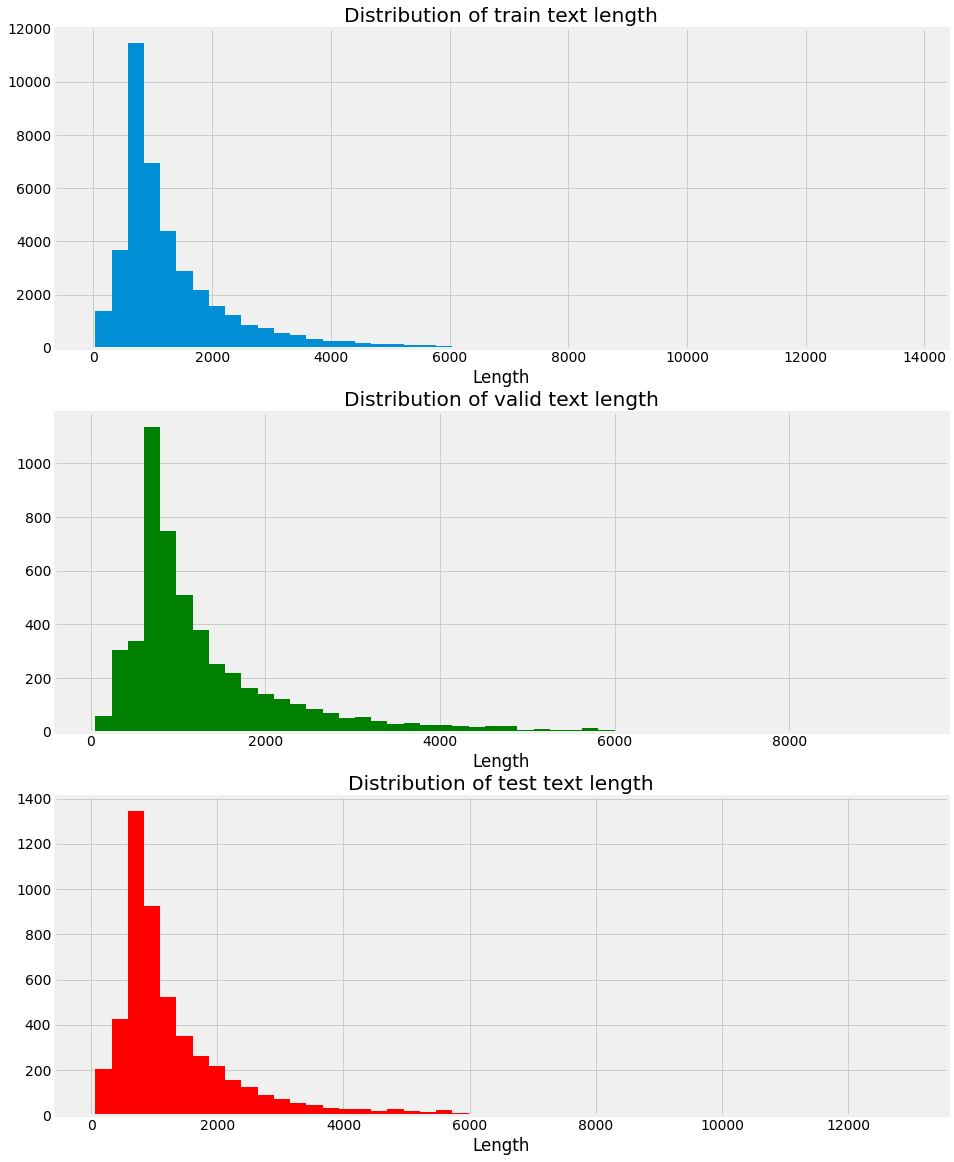

In [9]:
plt.figure(figsize=(16,20))
plt.style.use('fivethirtyeight')

plt.subplot(3,1,1)
train_len = [len(l) for l in train_x]
plt.hist(train_len,bins=50)
plt.title('Distribution of train text length')
plt.xlabel('Length')

plt.subplot(3,1,2)
valid_len = [len(l) for l in valid_x]
plt.hist(valid_len,bins=50,color='green')
plt.title('Distribution of valid text length')
plt.xlabel('Length')

plt.subplot(3,1,3)
test_len = [len(l) for l in test_x]
plt.hist(test_len,bins=50,color='red')
plt.title('Distribution of test text length')
plt.xlabel('Length')

plt.show()

In [10]:
def bigram(x, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(x)
    bag_of_words = vec.transform(x)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [11]:
import plotly as py
import cufflinks as cf
from plotly.offline import iplot
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.feature_extraction.text import CountVectorizer

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [12]:
common_words = bigram(train_x, 25)
df2 = pd.DataFrame(common_words, columns = ['Bigram Text', 'Count'])
df2.groupby('Bigram Text').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Frequency',title='Bigram - The distribution of Top 25')

In [13]:
common_words = bigram(valid_x, 25)
df2 = pd.DataFrame(common_words, columns = ['Bigram Text', 'Count'])
df2.groupby('Bigram Text').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Frequency',title='Bigram - The distribution of Top 25')

In [14]:
common_words = bigram(test_x, 25)
df2 = pd.DataFrame(common_words, columns = ['Bigram Text', 'Count'])
df2.groupby('Bigram Text').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Frequency',title='Bigram - The distribution of Top 25')

## Visualize the practical words that represent positive and negative sentiment in the dataset.


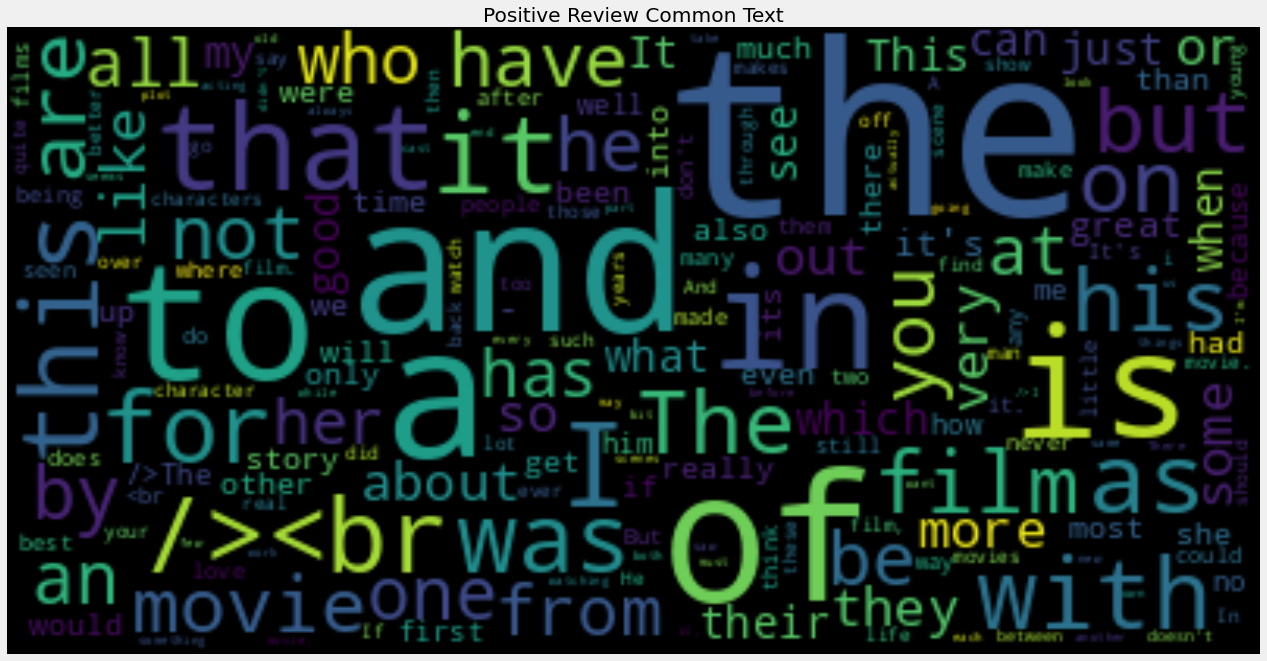

In [15]:
plt.figure(figsize=(20,20))
pos_freq = FreqDist(' '.join(train[train['label'] == 1].text).split(' '))
wc = WordCloud().generate_from_frequencies(frequencies=pos_freq)
plt.imshow(wc,interpolation='bilinear')
plt.title('Positive Review Common Text')
plt.axis('off')
plt.show()

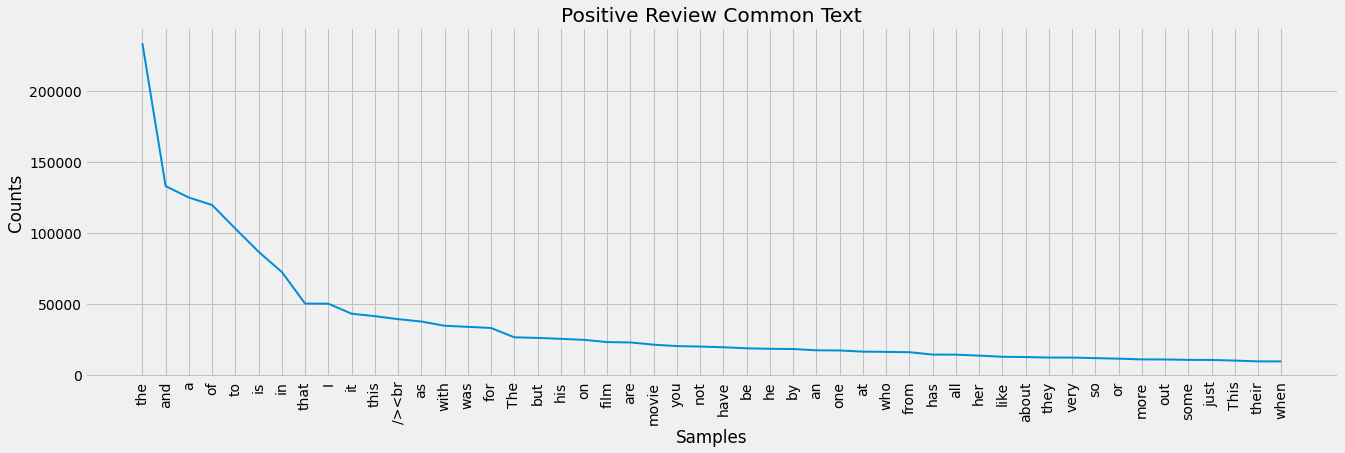

In [16]:
plt.figure(figsize=(20,6))
pos_freq.plot(50,cumulative=False,title='Positive Review Common Text')
plt.show()

***WORDCLOUD for Negative Text***

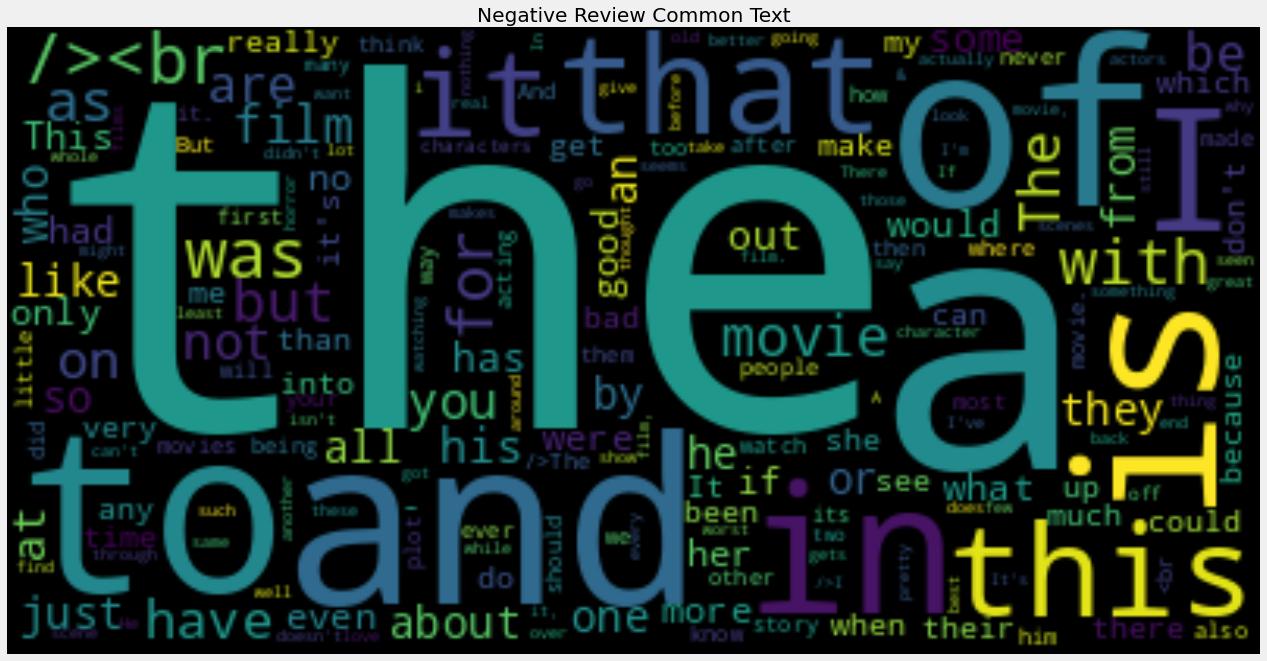

In [17]:
plt.figure(figsize=(20,20))
neg_freq = FreqDist(' '.join(train[train['label'] == 0].text).split(' '))
wc = WordCloud().generate_from_frequencies(frequencies=neg_freq)
plt.imshow(wc,interpolation='bilinear')
plt.title('Negative Review Common Text')
plt.axis('off')
plt.show()

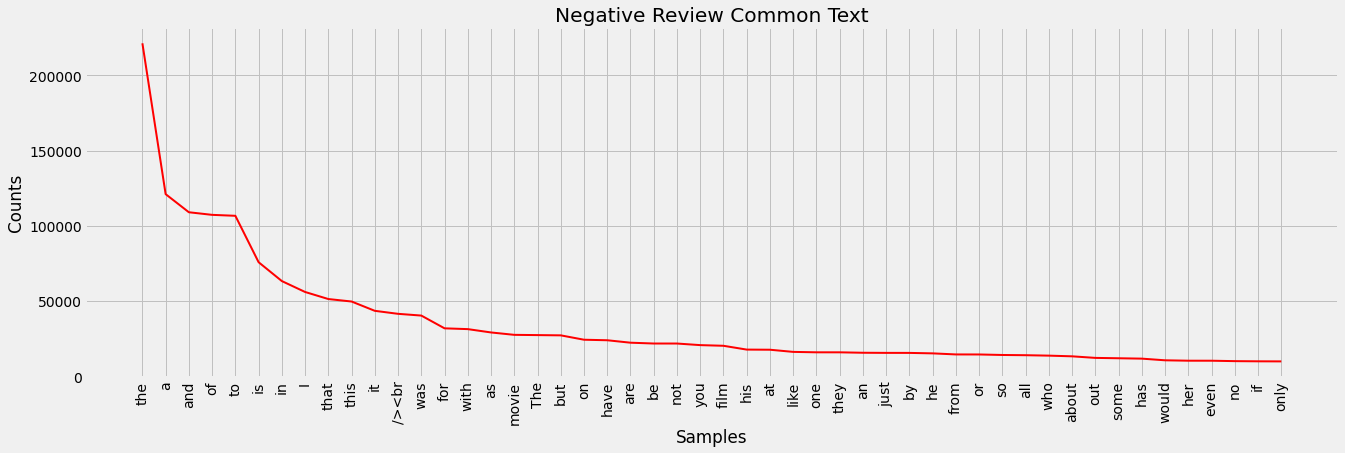

In [18]:
plt.figure(figsize=(20,6))
neg_freq.plot(50,cumulative=False,title='Negative Review Common Text',color='red')
plt.show()

## Text pre-processing – 

- lowering text

- removing URLs 

- punctuation 

- stop words 

- correct spelling

In [19]:
def Preprocessing(text):
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"http\S+", "", text)
    text = text.lower()
    text = [w for w in text.split(' ') if w not in stopwords.words('english')]
    text = listToString(text)
    text = TextBlob(text)            # Making our first textblob
    text = text.correct()
    text = [WordNetLemmatizer().lemmatize(token) for token in text]
    #text = [WordNetLemmatizer().lemmatize(token,pos='v') for token in text]
    text = " ".join(text)
    return text

train_x = train_x.apply(lambda x:Preprocessing(x))
valid_x = valid_x.apply(lambda x:Preprocessing(x))
test_x= test_x.apply(lambda x:Preprocessing(x))
Custom_df_x= Custom_df_x.apply(lambda x:Preprocessing(x))

## Perform tokenization and lemmatization on cleaned data .

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Tokenize the sentences
tokenizer = Tokenizer()
#preparing vocabulary
tokenizer.fit_on_texts(train_x)
#converting text into integer sequences
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x)
#padding to prepare sequences of same length
train_x=pad_sequences(train_x,maxlen=120)
valid_x=pad_sequences(valid_x,maxlen=120)
test_x=pad_sequences(test_x,maxlen=120)
Custom_df_x = tokenizer.texts_to_sequences(Custom_df_x)
#padding to prepare sequences of same length
Custom_df_x=pad_sequences(Custom_df_x,maxlen=120)

In [21]:
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

87


## Create an embedding layer and build a 15 layer LSTM and a 20 layer BidRNN forpredicting the sentiment.

In [22]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
#embedding layer
model.add(Embedding(size_of_vocabulary,128,input_length=120))
#lstm layer
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
"""model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2)))"""
#Global Maxpooling
model.add(GlobalMaxPooling1D())
#Dense Layer
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1,activation='sigmoid'))
#Add loss function, metrics, optimizer
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#Adding callbacks
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)
#summary
model.summary()

2022-09-26 17:11:13.639750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 17:11:13.640944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 17:11:13.641650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 17:11:13.642574: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 128)          11136     
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          98816     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 114,113
Trainable params: 114,113
Non-trainable params: 0
__________________________________________________

In [23]:
history = model.fit(train_x,train_y,batch_size=128,epochs=4,
                    validation_data=(valid_x,valid_y),verbose=1,callbacks=[es,mc])


2022-09-26 17:11:17.233309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4


2022-09-26 17:11:20.715676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 11s 19ms/step - loss: 0.6665 - accuracy: 0.5767 - val_loss: 0.6269 - val_accuracy: 0.6348

Epoch 00001: val_accuracy improved from -inf to 0.63480, saving model to best_model.h5
Epoch 2/4
313/313 [==============================] - 5s 17ms/step - loss: 0.5963 - accuracy: 0.6651 - val_loss: 0.5755 - val_accuracy: 0.6878

Epoch 00002: val_accuracy improved from 0.63480 to 0.68780, saving model to best_model.h5
Epoch 3/4
313/313 [==============================] - 5s 17ms/step - loss: 0.5610 - accuracy: 0.6974 - val_loss: 0.5548 - val_accuracy: 0.6966

Epoch 00003: val_accuracy improved from 0.68780 to 0.69660, saving model to best_model.h5
Epoch 4/4
313/313 [==============================] - 5s 17ms/step - loss: 0.5350 - accuracy: 0.7187 - val_loss: 0.5422 - val_accuracy: 0.7070

Epoch 00004: val_accuracy improved from 0.69660 to 0.70700, saving model to best_model.h5


## Evaluating the performance of the model

***Accuracy***

In [24]:
#loading best model
model = load_model('best_model.h5')
# evaluate
loss,acc = model.evaluate(test_x,test_y)
print('Test Accuracy: {}%'.format(acc*100))

157/157 [==============================] - 1s 5ms/step - loss: 0.5356 - accuracy: 0.7182
Test Accuracy: 71.82000279426575%


***Confusion Metrics***

In [25]:
#perdict test
ypred = model.predict(test_x)
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0
#Confusion Metrics
print(confusion_matrix(test_y,ypred))

[[2010  485]
 [ 924 1581]]


***Classification Report***

In [26]:
print(classification_report(test_y,ypred))

              precision    recall  f1-score   support

           0       0.69      0.81      0.74      2495
           1       0.77      0.63      0.69      2505

    accuracy                           0.72      5000
   macro avg       0.73      0.72      0.72      5000
weighted avg       0.73      0.72      0.72      5000



***ROC***

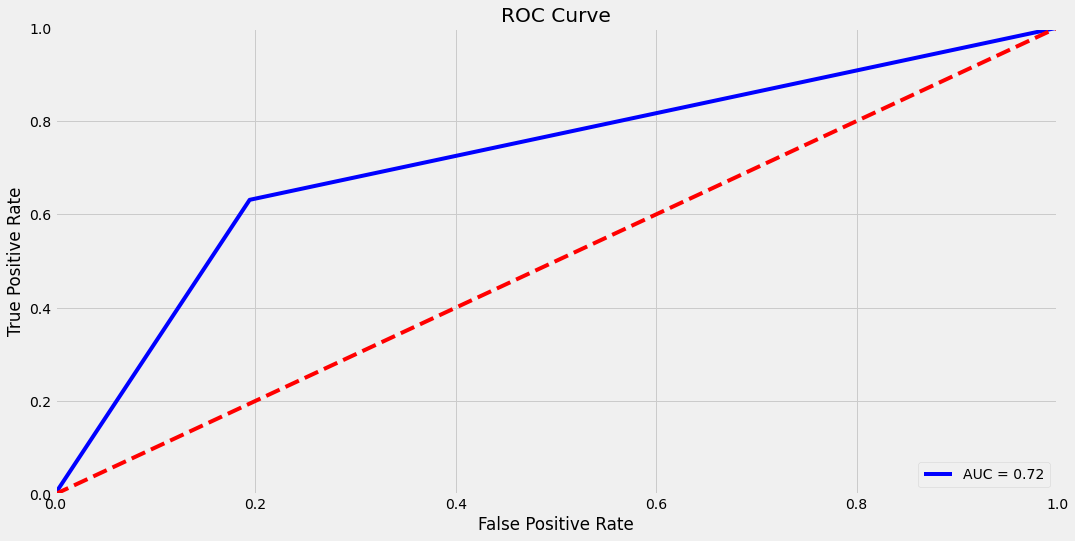

In [27]:
#plot roc
plt.figure(figsize=(16,8))
fpr,tpr,threshold = roc_curve(test_y,ypred)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Build your own test dataset with 10 movie reviews and tabulate accuracy.

1/1 [==============================] - 1s 636ms/step - loss: 0.8210 - accuracy: 0.3000
Test Accuracy: 30.000001192092896%
[[2 3]
 [4 1]]
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.25      0.20      0.22         5

    accuracy                           0.30        10
   macro avg       0.29      0.30      0.29        10
weighted avg       0.29      0.30      0.29        10



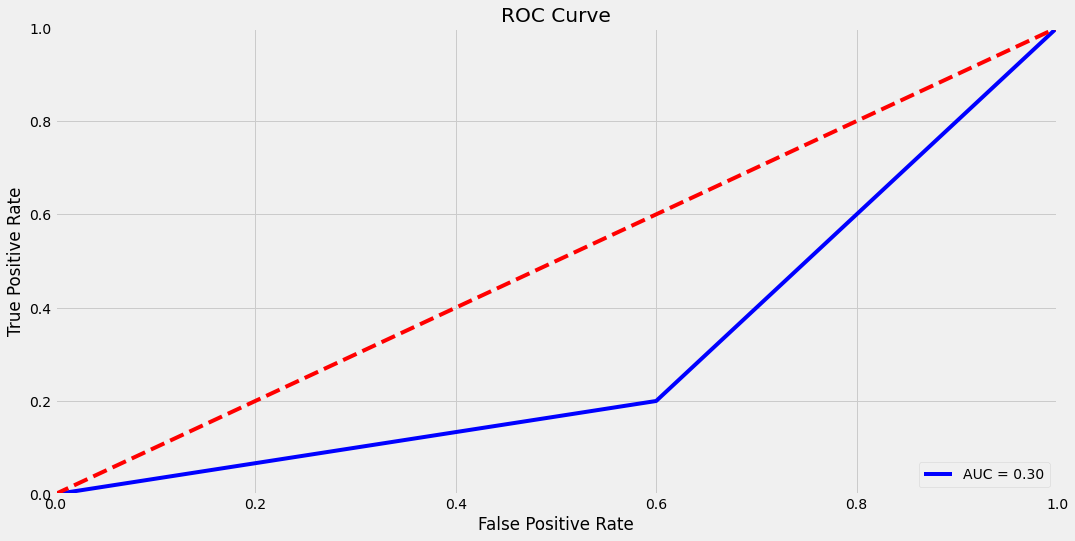

In [28]:
#loading best model
model = load_model('best_model.h5')
# evaluate
loss,acc = model.evaluate(Custom_df_x,Custom_df_y)
print('Test Accuracy: {}%'.format(acc*100))
#perdict test
ypred = model.predict(Custom_df_x)
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0
#Confusion Metrics
print(confusion_matrix(Custom_df_y,ypred))
print(classification_report(Custom_df_y,ypred))
#plot roc
plt.figure(figsize=(16,8))
fpr,tpr,threshold = roc_curve(Custom_df_y,ypred)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model1 = Sequential()
#embedding layer
model1.add(Embedding(size_of_vocabulary,128,input_length=120))
#lstm layer
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
"""model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))
model1.add(Bidirectional(SimpleRNN(64, return_sequences=True,dropout=0.2)))"""
#Global Maxpooling
model1.add(GlobalMaxPooling1D())
#Dense Layer
model1.add(Dense(32,activation='relu'))
model1.add(Dropout(0.05))
model1.add(Dense(1,activation='sigmoid'))
#Add loss function, metrics, optimizer
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#Adding callbacks
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)
#summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 128)          11136     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 128)          24704     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 40,001
Trainable params: 40,001
Non-trainable params: 0
__________________________________________________

In [30]:
history = model1.fit(train_x,train_y,batch_size=128,epochs=4,
                    validation_data=(valid_x,valid_y),verbose=1,callbacks=[es,mc])


Epoch 1/4
313/313 [==============================] - 88s 275ms/step - loss: 0.6799 - accuracy: 0.5476 - val_loss: 0.6518 - val_accuracy: 0.5786

Epoch 00001: val_accuracy improved from -inf to 0.57860, saving model to best_model1.h5
Epoch 2/4
313/313 [==============================] - 88s 281ms/step - loss: 0.6028 - accuracy: 0.6549 - val_loss: 0.5716 - val_accuracy: 0.6878

Epoch 00002: val_accuracy improved from 0.57860 to 0.68780, saving model to best_model1.h5
Epoch 3/4
313/313 [==============================] - 86s 275ms/step - loss: 0.5572 - accuracy: 0.7021 - val_loss: 0.5426 - val_accuracy: 0.7072

Epoch 00003: val_accuracy improved from 0.68780 to 0.70720, saving model to best_model1.h5
Epoch 4/4
313/313 [==============================] - 88s 283ms/step - loss: 0.5334 - accuracy: 0.7179 - val_loss: 0.5265 - val_accuracy: 0.7250

Epoch 00004: val_accuracy improved from 0.70720 to 0.72500, saving model to best_model1.h5


In [31]:
#loading best model1
model1 = load_model('best_model1.h5')
# evaluate
loss,acc = model1.evaluate(test_x,test_y)
print('Test Accuracy: {}%'.format(acc*100))

157/157 [==============================] - 3s 17ms/step - loss: 0.5366 - accuracy: 0.7202
Test Accuracy: 72.02000021934509%


In [32]:
#perdict test
ypred = model1.predict(test_x)
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0
#Confusion Metrics
print(confusion_matrix(test_y,ypred))

[[1949  546]
 [ 853 1652]]


In [33]:
print(classification_report(test_y,ypred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      2495
           1       0.75      0.66      0.70      2505

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



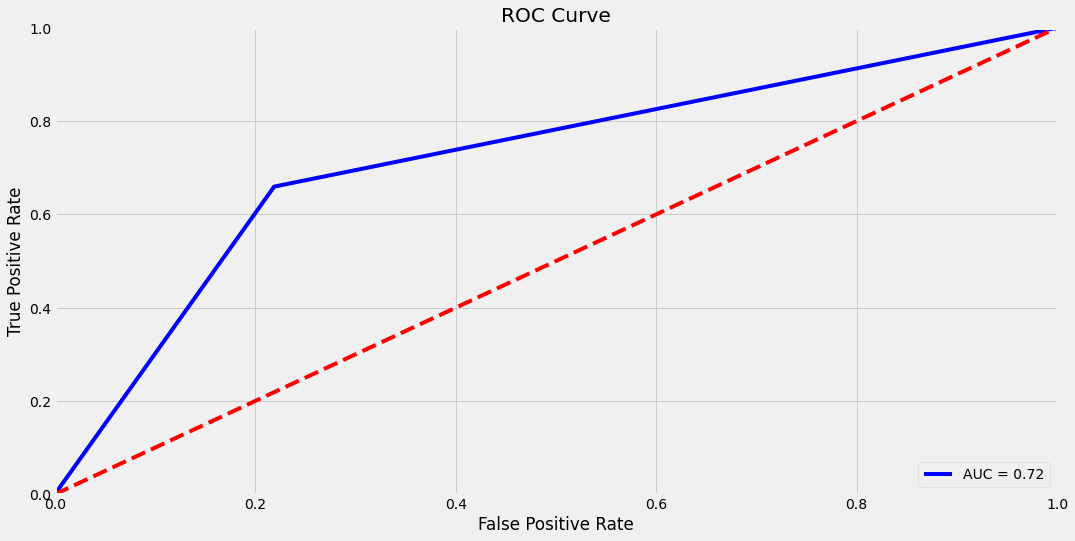

In [34]:
#plot roc
plt.figure(figsize=(16,8))
fpr,tpr,threshold = roc_curve(test_y,ypred)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Build your own test dataset with 10 movie reviews and tabulate accuracy.

1/1 [==============================] - 0s 20ms/step - loss: 0.8210 - accuracy: 0.3000
Test Accuracy: 30.000001192092896%
[[2 3]
 [4 1]]
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.25      0.20      0.22         5

    accuracy                           0.30        10
   macro avg       0.29      0.30      0.29        10
weighted avg       0.29      0.30      0.29        10



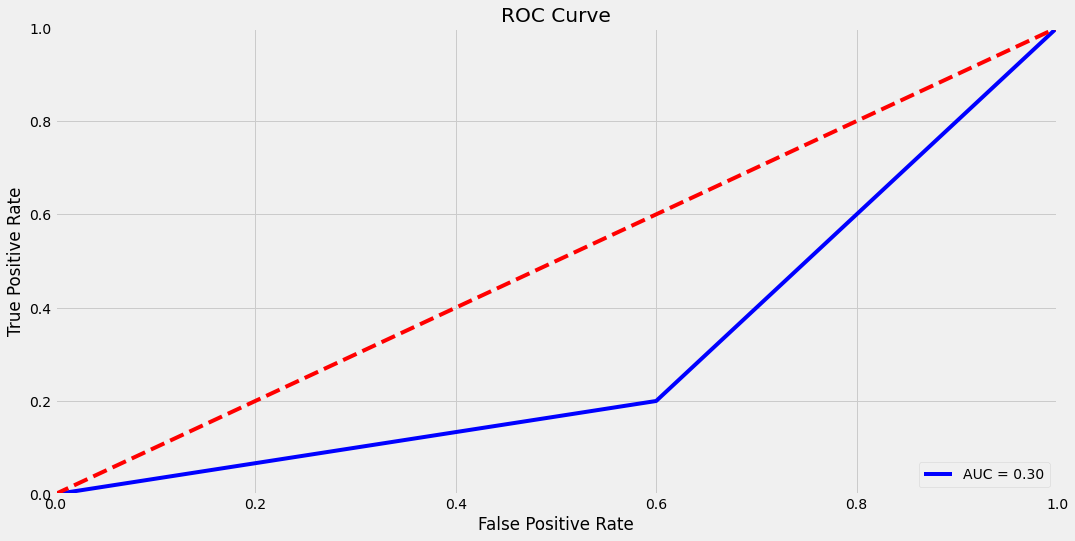

In [35]:
#loading best model
model1 = load_model('best_model1.h5')
# evaluate
loss,acc = model.evaluate(Custom_df_x,Custom_df_y)
print('Test Accuracy: {}%'.format(acc*100))
#perdict test
ypred = model.predict(Custom_df_x)
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0
#Confusion Metrics
print(confusion_matrix(Custom_df_y,ypred))
print(classification_report(Custom_df_y,ypred))
#plot roc
plt.figure(figsize=(16,8))
fpr,tpr,threshold = roc_curve(Custom_df_y,ypred)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()